In [68]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [69]:
from sklearn import linear_model
from scipy import signal, ndimage
from skimage import data
#from skimage.transform import rescale, resize

In [70]:
from scipy.ndimage import gaussian_filter
import random
import math
import copy

## PSF

In [71]:
def gaussian_psf(size=11, sigma=1.0):
    """
    Create a Gaussian Point Spread Function.

    Parameters:
    - size: Size of the PSF (should be odd)
    - sigma: Standard deviation of the Gaussian distribution

    Returns:
    - 2D numpy array representing the Gaussian PSF
    """
    x, y = np.meshgrid(np.linspace(-size//2, size//2, size),
                       np.linspace(-size//2, size//2, size))

    # Gaussian function
    psf = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Normalize the PSF
    return psf / np.sum(psf)

In [72]:
def diffraction_limited_psf(size, wavelength, aperture):#(size=11, wavelength=0.5, aperture=1.0):
    """
    Create a diffraction-limited (Airy disk) Point Spread Function.

    Parameters:
    - size: Size of the PSF (should be odd)
    - wavelength: Optical wavelength
    - aperture: Diameter of the circular aperture

    Returns:
    - 2D numpy array representing the diffraction-limited PSF
    """
    x, y = np.meshgrid(np.linspace(-size//2, size//2, size),
                       np.linspace(-size//2, size//2, size))

    # Normalized radius
    r = np.sqrt(x**2 + y**2)

    # Compute Airy disk PSF
    k = 2 * np.pi / wavelength
    alpha = k * aperture * r / (2 * size)

    # Airy disk function
    psf = (2 * np.sin(alpha) / alpha)**2

    # Normalize the PSF
    return psf / np.sum(psf)

In [73]:
def motion_blur_psf(size=11, angle=45, length=9):
    """
    Create a motion blur Point Spread Function.

    Parameters:
    - size: Size of the PSF (should be odd)
    - angle: Angle of motion blur in degrees
    - length: Length of the motion blur

    Returns:
    - 2D numpy array representing the motion blur PSF
    """
    # Create a line PSF
    psf = np.zeros((size, size))

    # Convert angle to radians
    theta = np.deg2rad(angle)

    # Create motion blur line
    for i in range(length):
        x = int(i * np.cos(theta))
        y = int(i * np.sin(theta))

        # Ensure coordinates are within the PSF
        if 0 <= size//2 + x < size and 0 <= size//2 + y < size:
            psf[size//2 + y, size//2 + x] = 1

    # Normalize the PSF
    return psf / np.sum(psf)

In [74]:
np.random.seed(30)

## Define number of agents

In [75]:
n_ag = 4#6#3#4#2
param = {'n':n_ag}

In [76]:
def generate_test_problem(n_ag, psf_size = 15):
    """
    Generate a test problem for Poisson image reconstruction.

    Parameters:
    -----------
    n_ag : int
        Number of agents
    psf_size: int
        Size of the PSF (should be odd)

    Returns:
    --------
    tuple
        (X_out, y_aux, y_meas, x_true.ravel()) - measurement matrix, measurements, and true object
    """

    # Generate true object (non-negative)

    ##x_true = np.abs(np.random.randn(n_object)) + 10
    #########################################################################
    #x_true = np.zeros((20, 20)) + 100
    #x_true[2:18, 2:18] = 80
    #x_true[4:16, 4:16] = 10
    #x_true[6:14, 6:14] = 50
    #x_true[7:13, 7:13] = 10
    #x_true[9:11, 9:11] = 60
    #########################################################################

    #########################################################################
    # simple image #
    size=64
    x_true = np.zeros((size, size))
    # Add a square
    square_size = size // 4
    start = size // 3
    x_true[start:start+square_size, start:start+square_size] = 1.0
    # Add a circle
    center = (size // 2, size // 2 + size // 4)
    radius = size // 6
    y, x = np.ogrid[:size, :size]
    dist = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    x_true[dist <= radius] = 0.8
    #########################################################################

    #########################################################################
    # phantom-like #
    #size = 64
    #phantom = np.zeros((size, size))

    ## Create outer ellipse (skull)
    #center = np.array([size//2, size//2])
    #radii = np.array([size*0.4, size*0.35])
    #y, x = np.ogrid[:size, :size]
    #dist = ((x - center[0])**2 / radii[0]**2) + ((y - center[1])**2 / radii[1]**2)
    #phantom[dist <= 1.0] = 0.8

    ## Create inner ellipse (brain)
    #center_inner = center.copy()
    #radii_inner = np.array([size*0.3, size*0.25])
    #dist_inner = ((x - center_inner[0])**2 / radii_inner[0]**2) + ((y - center_inner[1])**2 / radii_inner[1]**2)
    #phantom[dist_inner <= 1.0] = 0.5

    ## Create two small ellipses (ventricles)
    #center_v1 = center.copy() + np.array([0, -size*0.1])
    #radii_v1 = np.array([size*0.05, size*0.05])
    #dist_v1 = ((x - center_v1[0])**2 / radii_v1[0]**2) + ((y - center_v1[1])**2 / radii_v1[1]**2)
    #phantom[dist_v1 <= 1.0] = 0.9

    #center_v2 = center.copy() + np.array([0, size*0.1])
    #radii_v2 = np.array([size*0.05, size*0.05])
    #dist_v2 = ((x - center_v2[0])**2 / radii_v2[0]**2) + ((y - center_v2[1])**2 / radii_v2[1]**2)
    #phantom[dist_v2 <= 1.0] = 0.9
    #x_true = copy.deepcopy(phantom)
    #########################################################################


    y_aux = np.zeros((param['n'],x_true.size))
    y_meas = np.zeros((param['n'],x_true.size))
    X_out = np.zeros((param['n'],x_true.size,x_true.size))
    psf = np.zeros((param['n'],psf_size,psf_size))

    for ag in range(n_ag):

      psf[ag] = gaussian_psf(size=psf_size, sigma=1.0*(ag+1))

      mean_measurements = ndimage.convolve(x_true, psf[ag], mode='constant') #blurring
      y_meas[ag] = mean_measurements.ravel()

      scaling_factor = 1000
      scaled_image = mean_measurements * scaling_factor #mean_measurements + 0.01 * np.random.randn(*mean_measurements.shape)
      noisy_blurred = np.random.poisson(scaled_image) / scaling_factor
      y_aux[ag,:] = np.clip(noisy_blurred, 0, 1).ravel()

    return X_out, y_aux, y_meas, x_true.ravel(), psf

In [77]:
#param = {'b':0}
param['b'] = 0

In [78]:
X_aux, y_aux, y_meas, x_true, param['psf'] = generate_test_problem(param['n'], 15) #, noise_level=1.0)

In [79]:
param['n_features'] = len(x_true) #n_features
#param['n_samples'] = n_samples
param['d'] = int(np.sqrt(len(x_true)))

In [80]:
print(np.min(x_true),np.max(x_true))
for ag in range(n_ag):
  #print(KL_ag(ag,param['x_true'],param)) #param['x_true']
  print(np.min(y_aux[ag]),np.max(y_aux[ag]))

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


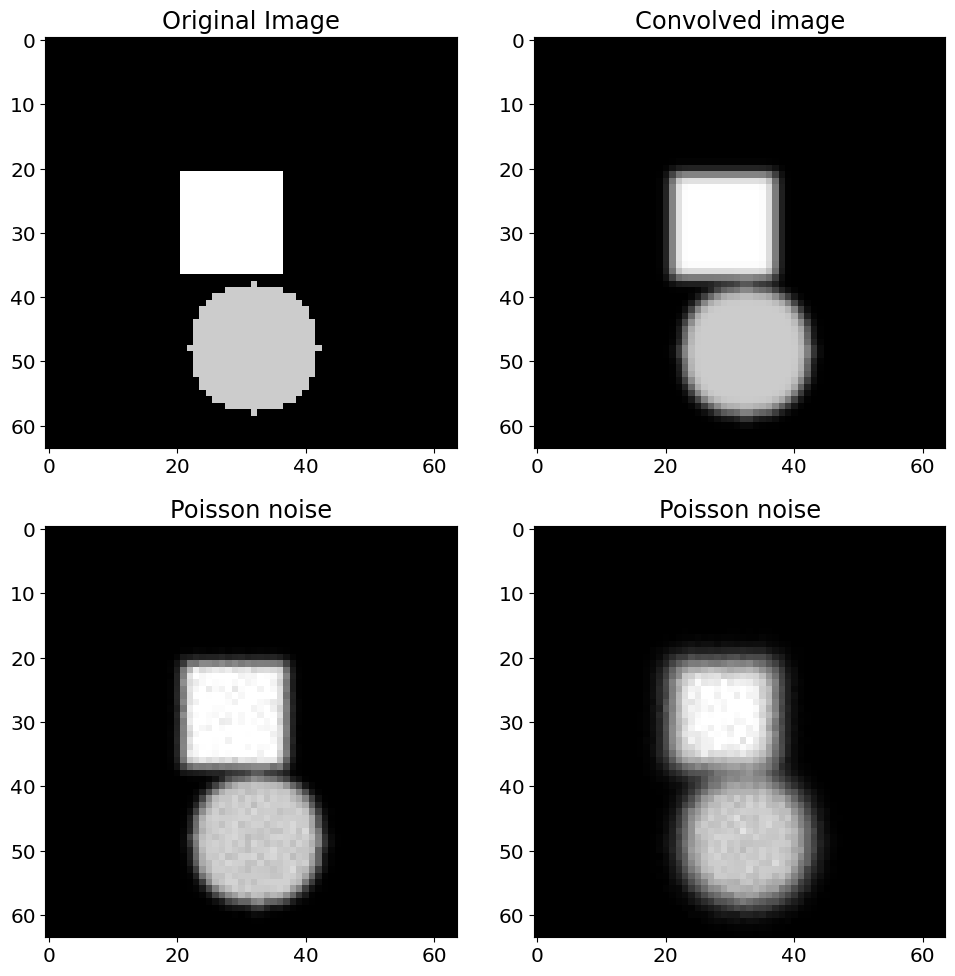

In [81]:
n_dim = int(np.sqrt(x_true.size))

fig, axs = plt.subplots(2,2, figsize=(10, 10))

axs[0,0].imshow(np.reshape(x_true, (n_dim, n_dim)), cmap='gray')
axs[0,0].set_title('Original Image')

#axs[1].imshow(np.reshape(y_aux[0], (n_dim, n_dim)), cmap='gray')
axs[0,1].imshow(np.reshape(y_meas[0], (n_dim, n_dim)), cmap='gray')
axs[0,1].set_title('Convolved image')

axs[1,0].imshow(np.reshape(y_aux[0], (n_dim, n_dim)), cmap='gray')
axs[1,0].set_title('Poisson noise')

axs[1,1].imshow(np.reshape(y_aux[1], (n_dim, n_dim)), cmap='gray')
axs[1,1].set_title('Poisson noise')

plt.tight_layout()
plt.show()

In [82]:
param['y'] = y_aux
param['x'] = X_aux

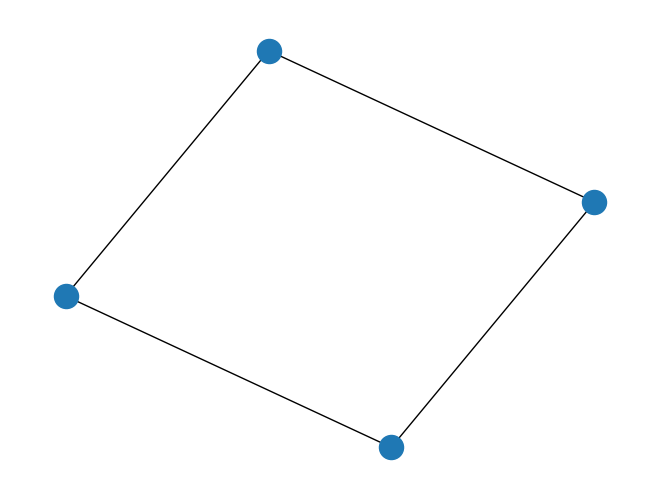

In [83]:
G = nx.cycle_graph(n_ag) #erdos_renyi_graph(param['n'], 0.4, seed=123, directed=False)
pos = nx.spring_layout(G, seed=47)  # Seed layout for reproducibility
nx.draw(G, pos=pos)
plt.show()

In [84]:
Ad = nx.adjacency_matrix(G).todense()
print('Adjacency matrix: ', Ad)
Neigh = [[] for ag in range(param['n'])]#np.zeros((param['n'],param['n']))
for i in range(param['n']):
  Neigh[i] = [i]
  Neigh[i] += np.where(Ad[i,:]==1)[0].tolist() #np.sum(Ad[i,:])
print('Neighbors: ', Neigh)

Adjacency matrix:  [[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]
Neighbors:  [[0, 1, 3], [1, 0, 2], [2, 1, 3], [3, 0, 2]]


In [85]:
param['neigh'] = Neigh

In [86]:
Lap = nx.laplacian_matrix(G).toarray()
print('Graph Laplacian: ', Lap)
Lap_max_eigen = np.linalg.eigvalsh(Lap)[-1]
tau_W = 1.5*Lap_max_eigen

Graph Laplacian:  [[ 2 -1  0 -1]
 [-1  2 -1  0]
 [ 0 -1  2 -1]
 [-1  0 -1  2]]


In [87]:
if param['n'] == 1:
    W = np.array([1.0])
    print('Mixing matrix: ', W)
else:
    W = np.identity(param['n']) - Lap/tau_W
    print('Mixing matrix: ', W)
param.update({'W':W})

Mixing matrix:  [[0.66666667 0.16666667 0.         0.16666667]
 [0.16666667 0.66666667 0.16666667 0.        ]
 [0.         0.16666667 0.66666667 0.16666667]
 [0.16666667 0.         0.16666667 0.66666667]]


In [88]:
if param['n'] == 1:
    param['eig_min'] = 1.0
else:
    param['eig_min'] = np.linalg.eigvalsh(param['W'])[0]
print(param['eig_min'])

0.33333333333333326


Define the objective function for each agent (h_i), and the one for the sum over agents (h)

In [89]:
def KL_ag(ag,u_ag,param):
  # u_ag is raveled
  eps = np.finfo(float).eps
  u_ag_safe = np.maximum(u_ag, eps)

  p_indices = param['y'][ag] > 0
  aux = param['y'][ag][p_indices] * np.log(param['y'][ag][p_indices] / u_ag_safe[p_indices]) + u_ag_safe[p_indices] - param['y'][ag][p_indices]

  z_indices = ~p_indices
  aux_zero = u_ag_safe[z_indices]
  return (param['penal']/(2*param['n']))*np.linalg.norm(u_ag)**2 + np.sum(aux) + np.sum(aux_zero)

In [90]:
def stack_KL(xx,param):
  out = 0.0
  for i in range(param['n']):
    out += KL_ag(i,param['x'][i].dot(xx[i,:]) + param['b'], param)
  return out

In [91]:
def f(x):
  """
  Penalization
  """
  return np.linalg.norm(x,2)**2#np.linalg.norm(x,1)

In [92]:
def f_stack(beta,param):
    out = 0.0
    for ag in range(param['n']):
        out += f(beta[ag, :])
    return param['penal']*out

In [93]:
def prox_f(x,gamma,param):
  """
  Proximal operator of f
  """
  return x/(1.0+gamma*param['penal'])#np.sign(x)*np.maximum(np.abs(x)-gamma*param['penal'], 0)

In [94]:
def prox_f_stack(beta,gamma,param):
  out = np.zeros((param['n'],param['n_features']))
  for ag in range(param['n']):
    out[ag, :] = prox_f(beta[ag,:],gamma,param)
  return out

In [95]:
def KL_grad_ag(ag,conblur,H,param):
  """
    Compute gradient of KL divergence for deblurring.

    Parameters:
    -----------
    conblur : ndarray of agent ag
        Convolution of current estimate of the blurred image, it is assumed to be reshaped into shape d x d
        Convolution operator is performed outside
    H : ndarray
        Convolution kernel (PSF)

    Returns:
    --------
    gradient : ndarray od shape d x d
  """

  eps = np.finfo(float).eps

  Ax_safe = np.maximum(conblur, eps) # here conblur == convolve2d(blur, H, mode='same')

  ratio = param['y'][ag].reshape(Ax_safe.shape)/ Ax_safe #ratio[p_indices] = param['y'][ag][p_indices] / Ax_safe[p_indices]
  out = signal.convolve2d(1 - ratio, H, mode='same') #param['x'][ag].T @ (1 - ratio) #- (param['x'][i].T).dot( np.divide( param['y'][i] , ( +param['y'][i]) )    )
  return out

In [96]:
def KL_grad(blur,H,param):

  """
  blur: ndarray of size # agents x #length of raveled image
  """

  out = np.zeros_like(blur) #np.zeros((param['n'],param['n_features']))
  eps = np.finfo(float).eps

  for i in range(param['n']):
    Ax = signal.convolve2d(blur[ag].reshape((param['d'],param['d'])), H[ag], mode='same') # #reshape the raveled imaged into d x d size
    out[i,:] = KL_grad_ag(ag,Ax,H[ag],param).ravel() #param['x'][i].T @ (1 - ratio) #- (param['x'][i].T).dot( np.divide( param['y'][i] , ( +param['y'][i]) )    )
  return out

In [97]:
def in_pr(A,B):
    out = 0.0
    for ag in range(A.shape[0]):
        out += np.dot(A[ag,:], B[ag,:])
    #return np.sum(np.multiply(A,B))
    return out

# Methods

In [98]:
def beta_update1(input): #just projection
    return np.maximum(input, 0)

In [99]:
def beta_update2(input,s): #projection and l2
    return np.maximum(input/(1 + s), 0)

In [100]:
def beta_update3(input,s): #projection and l1
    return np.maximum(input - s, 0)

In [101]:
param['penal'] = 0.001

In [102]:
clf = linear_model.PoissonRegressor(fit_intercept=False, alpha = 2.0*param['penal'])
X = X_aux[0] #np.pad(X_aux[0], pad_width=int((100-20)/2), mode='constant', constant_values=0)#X_aux[0]#X_train
y = y_aux[0] #np.concatenate(y_aux)#y_train
clf.fit(X,y)
clf.score(X,y)
clf.coef_

array([0., 0., 0., ..., 0., 0., 0.])

In [103]:
b0 = clf.coef_#np.random.normal(1, 0.5, 1)[0]/5
#bb = np.ones((param['n'],param['n_features'])) #np.zeros((param['n'],param['n_features']))
#for ag in range(param['n']):
    #bb[ag,:] = b0

## PGEXTRA

In [104]:
def PGEXTRA(a_prev,tau,param):

    feasV = []
    stepV = []

    # initialize
    w = param['W']@a_prev - tau*KL_grad(a_prev,param['psf'],param)#grad_h_stack(a_prev,param)
    a = beta_update3(w,tau*param['penal'])
    #a = beta_update2(w,param['penal']*param['beta']*tau) #prox_f_stack(w,tau,param)

    #OV.append(stack_KL(a,param))
    err = np.sqrt(in_pr(a-a_prev,a-a_prev))
    stepV += [err]
    Wt = np.eye(param['W'].shape[0]) - param['W']
    feas = np.sqrt(in_pr(Wt@a,Wt@a))
    feasV += [feas]

    W2 = 0.5*(np.eye(param['n']) + param['W'])

    for k in range(param['k_max']):
        w_next = w - a + W2@(2.0 * a - a_prev) - tau*(KL_grad(a,param['psf'],param)-KL_grad(a_prev,param['psf'],param)) #param['W']@a + w - 0.5*(param['W']+np.eye(param['n']))@a_prev - tau*(grad_h_stack(a,param)-grad_h_stack(a_prev,param))
        a_next = beta_update3(w_next,tau*param['penal'])
        #a_next = beta_update2(w, param['penal']*tau)#prox_f_stack(w_next,tau,param) #np.copy(w_next)

        #OV.append(stack_KL(a_next,param))
        err = np.sqrt(in_pr(a_next-a,a_next-a))
        stepV += [err]
        feas = np.sqrt(in_pr(Wt@a_next,Wt@a_next))
        feasV += [feas]
        if k % 100 == 0:
            print('it: ', k, ', error: ', err, ', feas. = ', feas)

        if np.maximum(err, feas)  < param['eps']:
            print('RETURN in iteration k = ',k)
            print('error = ', err, ' feasibility = ', feas)
            return a_next, stepV, feasV
        a_prev = copy.deepcopy(a)
        a = copy.deepcopy(a_next)
        w = copy.deepcopy(w_next)
    return a, stepV, feasV

## ADT

In [105]:
def ADT1(beta_init,u_init,t,param):
    """
    New method without linesearch, constant stepsize
    """
    beta = copy.deepcopy(np.array([param['beta']]))
    Wt = np.eye(param['W'].shape[0]) - param['W']
    #u_init = np.zeros()#0.5*t*Wt@beta_init
    beta_prev = copy.deepcopy(beta_init)
    u_prev = copy.deepcopy(u_init)
    OV = [1,1]
    #OV += [stack_KL(beta_prev,param)]
    feasV = []
    stepV = []


    for k in range(param['k_max']):

        # start iteration
        u = u_prev + 0.5 * t * Wt @ beta_prev
        u_bar = 2.0 * u - u_prev
        param['beta'] = param['beta']/(1.0 + param['penal']*param['beta']*t)
        #beta_next = beta_update1((beta_prev - param['beta']*t*(u_bar + param['penal']*beta_prev + KL_grad(beta_prev,param)))/(1.0+t*param['penal']*param['beta']))
        beta_next = beta_update2(beta_prev - param['beta']*t*(u_bar + KL_grad(beta_prev,param['psf'],param)), t*param['penal'])  #prox_f_stack(beta_prev - param['beta']*t*(u_bar + param['penal']*beta_prev + grad_h_stack(beta_prev,param)),t**(-1),param
        #beta_next = beta_update2(beta_prev - param['beta']*t*(u_bar + KL_grad(beta_prev,param)),param['penal']*param['beta']*t)  #prox_f_stack(beta_prev - (u_bar + dh)/t,t**(-1),param) # beta_prev - (u_bar + dh)/t

        err = np.sqrt(np.sum((beta_next-beta_prev)*(beta_next-beta_prev)))
        stepV += [err]
        feas = np.sqrt(np.sum((Wt@beta_next)*(Wt@beta_next)))
        feasV += [feas]

        if (len(OV) > 1 and np.maximum(err,feas) < param['eps']): # or rho > 200.0: # and rho < param['rho_tol']) or rho > 10.0: #OV[-1]-OV[-2] #err,
            print('RETURN in iteration k = ',k)
            print('error = ', err, ' feasibility = ', feas) #, ' quality = ', rho)
            return beta_next, stepV, feasV#, qual
        if k % param['k_print'] == 0:
            print('it: ', k, ', error: ', err, ', feas. = ', feas) #, ' quality = ', rho)
        beta_prev = copy.deepcopy(beta_next)
        u_prev = copy.deepcopy(u)
    param['beta'] = beta[0]
    #print('error = ', np.sqrt(in_pr(a-a_next,a-a_next)), ' feasibility = ', np.sqrt(in_pr(a_next - W@a_next,a_next - W@a_next)))
    return beta_prev, stepV, feasV#, qual

## ADT with linesearch

In [106]:
def rescale_output(x,y,z,w,v,p):
  min_val = np.min([np.min(x),np.min(y),np.min(z),np.min(w),np.min(v),np.min(p)])
  max_val = np.max([np.max(x),np.max(y),np.max(z),np.max(w),np.max(v),np.max(p)])
  x = 100*(x - min_val)/(max_val - min_val)
  y = 100*(y - min_val)/(max_val - min_val)
  z = 100*(z - min_val)/(max_val - min_val)
  w = 100*(w - min_val)/(max_val - min_val)
  v = 100*(v - min_val)/(max_val - min_val)
  p = 100*(p - min_val)/(max_val - min_val)
  return x,y,z,w,v, p

In [107]:
def plot_reconstruction(x_true, recon_img, param):
  fig, axs = plt.subplots(1, int(param['n']), figsize=(10, 10))

  axs[0].imshow(np.reshape(x_true, (param['n_dim'], param['n_dim'])), cmap='gray')
  axs[0].set_title('Original Image')

  axs[1].imshow(np.reshape(recon_img[0], (param['n_dim'], param['n_dim'])), cmap='gray')
  axs[1].set_title('copy 1')

  axs[2].imshow(np.reshape(recon_img[1], (param['n_dim'], param['n_dim'])), cmap='gray')
  axs[2].set_title('copy 2')

  #axs[3].imshow(np.reshape(recon_img[2], (10, 10)), cmap='gray')
  #axs[3].set_title('copy 3')

  plt.tight_layout()
  plt.show()

In [108]:
def ls(th,x_pr,u_pr,tau,param): #(theta, t_prev,u_prev,a_prev,rel_rho,param):
  """
  Implementation of linesearch
  """

  beta = np.array([param['beta']])

  x = copy.deepcopy(x_pr)
  sumW = np.zeros_like(x_pr)
  u = copy.deepcopy(u_pr) #u = np.copy(u_prev)
  dh = np.zeros_like(x_pr)
  Ax = np.zeros((param['n'],param['d'],param['d']))
  h_ant = np.zeros((param['n'],))

  for ag in range(param['n']):
    Ax[ag] = signal.convolve2d(x_pr[ag].reshape((param['d'],param['d'])), param['psf'][ag], mode='same')
    h_ant[ag] = KL_ag(ag,Ax[ag].ravel(), param)
    dh[ag] = KL_grad_ag(ag,Ax[ag],np.flipud(np.fliplr(param['psf'][ag])),param).ravel() #KL_grad_ag(ag,a_prev[ag],param)
    for ag_ in param['neigh'][ag]:
      sumW[ag] -= param['W'][ag,ag_]*x_pr[ag_]
    sumW[ag] += x_pr[ag]
    u[ag] = u_pr[ag] + 0.5*tau*sumW[ag]

  eps = np.finfo(float).eps
  alpha = np.sqrt(1 + 0.1*th)#1.0
  t_prev = copy.deepcopy(tau)
  t = np.min([t_prev*alpha, np.sqrt(2.0*param['deltaK']/(param['beta']*(1.0 - param['eig_min'])))]) # set t_0

  for j in range(param['j_max']):
      val = 0.0
      for ag in range(param['n']):
          param['beta'] = param['beta']/(1.0 + param['penal']*param['beta']*t)
          u_bar = u[ag] + t*(u[ag] - u_pr[ag])/t_prev
          x[ag] = beta_update2(x_pr[ag] - param['beta']*t*(u_bar + dh[ag]), t*param['penal'])

          Ax_next = signal.convolve2d(x[ag].reshape((param['d'],param['d'])), param['psf'][ag], mode='same') # #reshape the raveled imaged into d x d size
          h_next = KL_ag(ag,Ax_next.ravel(), param)
          val += t*(h_next - h_ant[ag] - np.sum(dh[ag]*(x[ag] - x_pr[ag]))) - param['deltaL']*np.linalg.norm(x[ag] - x_pr[ag],2)**2/(2.0*param['beta'])

      if val <= eps:#eps: #0:
          return t, x, u, j+1#, t_h#, ls_val, rel_rho
      t *= param['mu']
  return t, x, u, j+1#,t_h #, ls_val, rel_rho

In [109]:
def ADT_ls(beta_init,u_init,t,param):
    """
    New method without linesearch, constant stepsize
    """
    beta = copy.deepcopy(np.array([param['beta']]))
    Wt = np.eye(param['W'].shape[0]) - param['W']
    #u_init = np.zeros()#0.5*t*Wt@beta_init
    beta_prev = copy.deepcopy(beta_init)
    u_prev = copy.deepcopy(u_init)
    OV = [1,1]
    #OV += [stack_KL(beta_prev,param)]
    feasV = []
    stepV = []
    ls_tot = 0.0
    t_hist = [t]

    th = 1.0

    for k in range(param['k_max']):
        param['beta'] = param['beta']/(1.0 + param['penal']*param['beta']*t)
        t_next, beta_next, u_next, ls_it = ls(th, beta_prev,u_prev,t,param) #ls(beta_prev,u_prev,u,t,param)
        t_hist += [t_next]
        th = t_next/t
        ls_tot += ls_it
        err = np.sqrt(np.sum((beta_next-beta_prev)*(beta_next-beta_prev)))
        stepV += [err]
        feas = np.sqrt(np.sum((Wt@beta_next)*(Wt@beta_next)))
        feasV += [feas]

        if (len(OV) > 1 and np.maximum(err,feas) < param['eps']): # or rho > 200.0: # and rho < param['rho_tol']) or rho > 10.0: #OV[-1]-OV[-2] #err,
            print('RETURN in iteration k = ',k)
            print('error = ', err, ' feasibility = ', feas, ', stepsize = ', t_next, ' total # ls = ', ls_tot) #, ' quality = ', rho)
            return beta_next, stepV, feasV, t_hist, ls_tot#, qual
        if k % param['k_print'] == 0:
            print('it: ', k, ', error: ', err, ', feas. = ', feas, ', # ls = ', ls_it, ', stepsize = ', t_next) #, ' quality = ', rho)
        beta_prev = copy.deepcopy(beta_next)
        u_prev = copy.deepcopy(u_next)
        t = copy.deepcopy(t_next)
    param['beta'] = beta[0]
    print('RETURN in iteration k = ',k)
    print('error = ', err, ' feasibility = ', feas, ', stepsize = ', t_next, ' total # ls = ', ls_tot) #, ' quality = ', rho)
    #print('error = ', np.sqrt(in_pr(a-a_next,a-a_next)), ' feasibility = ', np.sqrt(in_pr(a_next - W@a_next,a_next - W@a_next)))
    return beta_prev, stepV, feasV, t_hist, ls_tot #, qual

In [110]:
def ls2(th,x_pr,u_pr,tau,param): #(theta, t_prev,u_prev,a_prev,rel_rho,param):
  """
  Implementation of linesearch
  """
  beta = copy.deepcopy(np.array([param['beta']]))

  x = copy.deepcopy(x_pr)
  sumW = np.zeros_like(x_pr)
  u = copy.deepcopy(u_pr) #u = np.copy(u_prev)
  dh = np.zeros_like(x_pr)
  Ax = np.zeros((param['n'],param['d'],param['d']))
  h_ant = np.zeros((param['n'],))

  av_ls = 0.0

  for ag in range(param['n']):
    Ax[ag] = signal.convolve2d(x_pr[ag].reshape((param['d'],param['d'])), param['psf'][ag], mode='same')
    h_ant[ag] = KL_ag(ag,Ax[ag].ravel(), param)
    dh[ag] = KL_grad_ag(ag,Ax[ag],np.flipud(np.fliplr(param['psf'][ag])),param).ravel() #KL_grad_ag(ag,a_prev[ag],param)
    for ag_ in param['neigh'][ag]:
      sumW[ag] -= param['W'][ag,ag_]*x_pr[ag_]
    sumW[ag] += x_pr[ag]
    u[ag] = u_pr[ag] + 0.5*tau*sumW[ag]

  eps = np.finfo(float).eps
  alpha = np.sqrt(1 + 0.1*th)#1.0
  t_prev = copy.deepcopy(tau)
  t = np.min([t_prev*alpha, np.sqrt(2.0*param['deltaK']/(param['beta']*(1.0 - param['eig_min'])))])*np.ones((param['n'],)) # set t_0

  for ag in range(param['n']):
    val = 0.0
    for j in range(param['j_max']):
      param['beta'] = param['beta']/(1.0 + param['penal']*param['beta']*t[ag])
      u_bar = u[ag] + t[ag]*(u[ag] - u_pr[ag])/t_prev
      x[ag] = beta_update2(x_pr[ag] - param['beta']*t[ag]*(u_bar + dh[ag]), t[ag]*param['penal'])
      Ax_next = signal.convolve2d(x[ag].reshape((param['d'],param['d'])), param['psf'][ag], mode='same')
      h_next = KL_ag(ag,Ax_next.ravel(), param)
      val = t[ag]*(h_next - h_ant[ag] - np.sum(dh[ag]*(x[ag] - x_pr[ag]))) - param['deltaL']*np.linalg.norm(x[ag] - x_pr[ag],2)**2/(2.0*param['beta'])
      #t_h[ag] += [t[ag]]
      if val <= eps:
        param['beta'] = beta[0]
        break
      t[ag] *= param['mu']
    av_ls += j+1
  t_min = np.min(t)
  param['beta'] = beta[0]/(1.0 + param['penal']*beta[0]*t_min)
  for ag in range(param['n']):
    if t[ag] > t_min + eps:
      x[ag] = beta_update2(x_pr[ag] - param['beta']*t_min*(u_bar + dh[ag]), t_min*param['penal'])

  return t_min, x, u, av_ls#, t_h #, ls_val, rel_rho

In [111]:
def ADT_ls2(beta_init,u_init,t,param):
    """
    New method without linesearch, constant stepsize
    """
    beta = copy.deepcopy(np.array([param['beta']]))
    Wt = np.eye(param['W'].shape[0]) - param['W']
    #u_init = np.zeros()#0.5*t*Wt@beta_init
    beta_prev = copy.deepcopy(beta_init)
    u_prev = copy.deepcopy(u_init)
    OV = [1,1]
    #OV += [stack_KL(beta_prev,param)]
    feasV = []
    stepV = []
    ls_tot = 0.0
    t_hist = [t]

    th = 1.0

    for k in range(param['k_max']):

        param['beta'] = param['beta']/(1.0 + param['penal']*param['beta']*t)
        t_next, beta_next, u_next, ls_it = ls2(th, beta_prev,u_prev,t,param) #ls(beta_prev,u_prev,u,t,param)
        t_hist += [t_next]
        th = t_next/t
        ls_tot += ls_it

        err = np.sqrt(np.sum((beta_next-beta_prev)*(beta_next-beta_prev)))
        stepV += [err]
        feas = np.sqrt(np.sum((Wt@beta_next)*(Wt@beta_next)))
        feasV += [feas]

        if (len(OV) > 1 and np.maximum(err,feas) < param['eps']): # or rho > 200.0: # and rho < param['rho_tol']) or rho > 10.0: #OV[-1]-OV[-2] #err,
            print('RETURN in iteration k = ',k)
            print('error = ', err, ' feasibility = ', feas, ', stepsize = ', t_next, ' total # ls = ', ls_tot) #, ' quality = ', rho)
            return beta_next, stepV, feasV, t_hist, ls_tot#, qual
        if k % param['k_print'] == 0:
            print('it: ', k, ', error: ', err, ', feas. = ', feas, ', # ls = ', ls_it, ', stepsize = ', t_next) #, ' quality = ', rho)
        beta_prev = copy.deepcopy(beta_next)
        u_prev = copy.deepcopy(u_next)
        t = copy.deepcopy(t_next)
    param['beta'] = beta[0]
    print('RETURN in iteration k = ',k)
    print('error = ', err, ' feasibility = ', feas, ', stepsize = ', t_next, ' total # ls = ', ls_tot) #, ' quality = ', rho)
    #print('error = ', np.sqrt(in_pr(a-a_next,a-a_next)), ' feasibility = ', np.sqrt(in_pr(a_next - W@a_next,a_next - W@a_next)))
    return beta_prev, stepV, feasV, t_hist, ls_tot#, qual

In [112]:
beta0 = np.zeros((param['n'], x_true.size))
#x_aux = x_true + 10*np.random.rand(x_true.size,)
x_true_stack = np.zeros((param['n'], x_true.size))
for ag in range(param['n']):
    beta0[ag] = x_true + 10*np.random.rand(x_true.size,) #x_aux #x_aux + np.random.rand(100,)/10
    x_true_stack[ag] = x_true
param['x_true_stack'] = x_true_stack
u0 = np.zeros(np.shape(beta0))
beta0 = y_aux

In [113]:
np.min(x_true), np.max(x_true)

(np.float64(0.0), np.float64(1.0))

In [114]:
#param['beta'] = 1.0 #1 #2.0
param['deltaL'] = 0.5
param['deltaK'] = 0.9999 - param['deltaL']
param['mu'] = 0.95

In [115]:
param['j_max'] = 100
param['k_max'] = 1500
param['k_print'] = int(param['k_max']/10)

param['x_true'] = x_true
#param['x_true_stack'] = x_true_stack
param['eps'] = 10**(-2)
param['n_dim'] = n_dim
param['rho_tol'] = 0.012

In [116]:
dd = np.random.rand(param['n'])

In [117]:
x_init = y_aux #np.ones_like(y_aux) #zeros_like(y_aux)#param['x_true_stack']#
u_init = np.zeros_like(y_aux)
#for ag in range(param['n']):
  #x_init[ag] =  np.eye(int(np.sqrt(len(param['x_true'])))).ravel()#0.0*param['x_true']  + 1.0*y_aux[ag] #+ 100*dd[ag]  #y_aux[ag] # np.eye(int(np.sqrt(len(y_aux[ag])))).ravel() #x_true_stack#beta0 #x_true_stack#x_true_stack #

In [118]:
in_pr(x_init - param['W'] @ x_init,x_init - param['W'] @ x_init)

np.float64(4.279318555555557)

In [119]:
param['beta'] = 2 #tau0**(-2)

In [120]:
#np.sqrt(2.0*param['deltaK']/(param['beta']*(1.0 - param['eig_min'])))
np.sqrt(2.0*param['deltaK']/(param['beta']*(1.0 - param['eig_min'])))

np.float64(0.8659387969135001)

In [121]:
#param['beta'] = 1.0
tau0 = 0.1*np.sqrt(2.0*param['deltaK']/(param['beta']*(1.0 - param['eig_min']))) #15 #10 #10.0*np.sqrt(2.0*param['deltaK']/(param['beta']*(1.0 - param['eig_min'])))
print(tau0)
param['t0'] = tau0

0.08659387969135002


In [122]:
param['beta']*tau0

np.float64(0.17318775938270004)

In [123]:
param['penal'] = 0.001 #0.001 #0.0001 #0.1 #10.0

In [124]:
x_PE, dx_PE, feas_PE = PGEXTRA(x_init,0.01,param)

it:  0 , error:  2.1127048711888183 , feas. =  0.520879364636129
it:  100 , error:  0.022154904453531084 , feas. =  0.00021004731669421918
it:  200 , error:  0.01227475081293253 , feas. =  0.00010987265044956847
RETURN in iteration k =  262
error =  0.009982379793611973  feasibility =  8.05974229173898e-05


In [125]:
x_ADT, dx_ADT, feas_ADT = ADT1(x_init,u_init,param['t0'],param)

it:  0 , error:  1.9881912139203988 , feas. =  1.9622128665661926
it:  150 , error:  0.17589222458867734 , feas. =  0.40529224791768703
it:  300 , error:  0.1361919801463852 , feas. =  0.675563759162749
it:  450 , error:  0.021764759371218224 , feas. =  0.7752772186024292
it:  600 , error:  0.0833032910292005 , feas. =  0.33727563150618173
it:  750 , error:  0.07236878641462341 , feas. =  0.16196751727887837
it:  900 , error:  0.04334513830659669 , feas. =  0.3483033197026325
it:  1050 , error:  0.012024481795043928 , feas. =  0.33495626549866453
it:  1200 , error:  0.026816948204069872 , feas. =  0.21790809348524923
it:  1350 , error:  0.034958934228452886 , feas. =  0.09170595674296209


In [126]:
dx_ADT[-1]

np.float64(0.030360502983229412)

In [127]:
##beta_1, t_1, val_1, step_hist_1, feas_1, qual_1 = ADT_ls(beta0, u0, tau0, param) #variable stepsize
#beta_1, t_1, val_1, step_hist_1, feas_1, qual_1, ls_track_1 = ADT_ls(x_init, u0, param)
x_1, dx_1, feas_1, t_hist_1, n_ls_1 = ADT_ls(x_init, u0, param['t0'], param) #(beta_init,u_init,t,param)

it:  0 , error:  2.513676191981422 , feas. =  2.0005740196808697 , # ls =  1 , stepsize =  0.0908204272176695
it:  150 , error:  0.02701696150374418 , feas. =  1.807473013550067 , # ls =  1 , stepsize =  0.005169631338450738
it:  300 , error:  0.0009638946781866435 , feas. =  1.6675929545159487 , # ls =  1 , stepsize =  0.00029429707930554505
it:  450 , error:  0.008829514964558347 , feas. =  1.5713040684351263 , # ls =  1 , stepsize =  0.002981093692626334
it:  600 , error:  0.0017698001039817115 , feas. =  1.3230880985576556 , # ls =  1 , stepsize =  0.0006445898046940543
it:  750 , error:  0.02118758475285131 , feas. =  1.0897158253679984 , # ls =  1 , stepsize =  0.008016982037199718
it:  900 , error:  0.0011591688277855987 , feas. =  0.9107592760252007 , # ls =  1 , stepsize =  0.00045639122868285087
it:  1050 , error:  0.011450777145154864 , feas. =  0.8160236508890228 , # ls =  1 , stepsize =  0.004623032672994635
it:  1200 , error:  0.00028960991761467334 , feas. =  0.754078184

In [128]:
##beta_cte1, t_cte1, val_cte1, step_hist_cte1, feas_cte1, qual_cte1 = ADT1(beta0, u0, tau0, param)#ADT1(beta0, u0, tau0, param) #ADT1(beta0, u0, tau0**(-1), param)
#beta_cte1, t_cte1, val_cte1, step_hist_cte1, feas_cte1, qual_cte1 = ADT1(x_init, u0, tau0, param) #ADT1(beta0, u0, tau0**(-1), param)
x_2, dx_2, feas_2, t_hist_2, n_ls_2 = ADT_ls2(x_init, u0, param['t0'], param)

it:  0 , error:  2.5142258031075273 , feas. =  2.0004972612087806 , # ls =  4.0 , stepsize =  0.0908204272176695
it:  150 , error:  0.0006532835720542064 , feas. =  1.7726516987661807 , # ls =  4.0 , stepsize =  0.00014598412389784851
it:  300 , error:  0.005030645589855403 , feas. =  1.6785157394829995 , # ls =  4.0 , stepsize =  0.001478751851708429
it:  450 , error:  0.020859817568616948 , feas. =  1.3956373557121258 , # ls =  4.0 , stepsize =  0.007321536263760845
it:  600 , error:  0.007027653927319329 , feas. =  1.0912134796605504 , # ls =  4.0 , stepsize =  0.0025943155020466385
it:  750 , error:  0.006804929679874506 , feas. =  0.8495357447306561 , # ls =  4.0 , stepsize =  0.002636036516575291
it:  900 , error:  0.0006871410381722493 , feas. =  0.7511260880214128 , # ls =  4.0 , stepsize =  0.0002735306699123748
it:  1050 , error:  0.006326857997536989 , feas. =  0.7968733460134283 , # ls =  4.0 , stepsize =  0.002679501843369436
it:  1200 , error:  0.008042502104571756 , feas

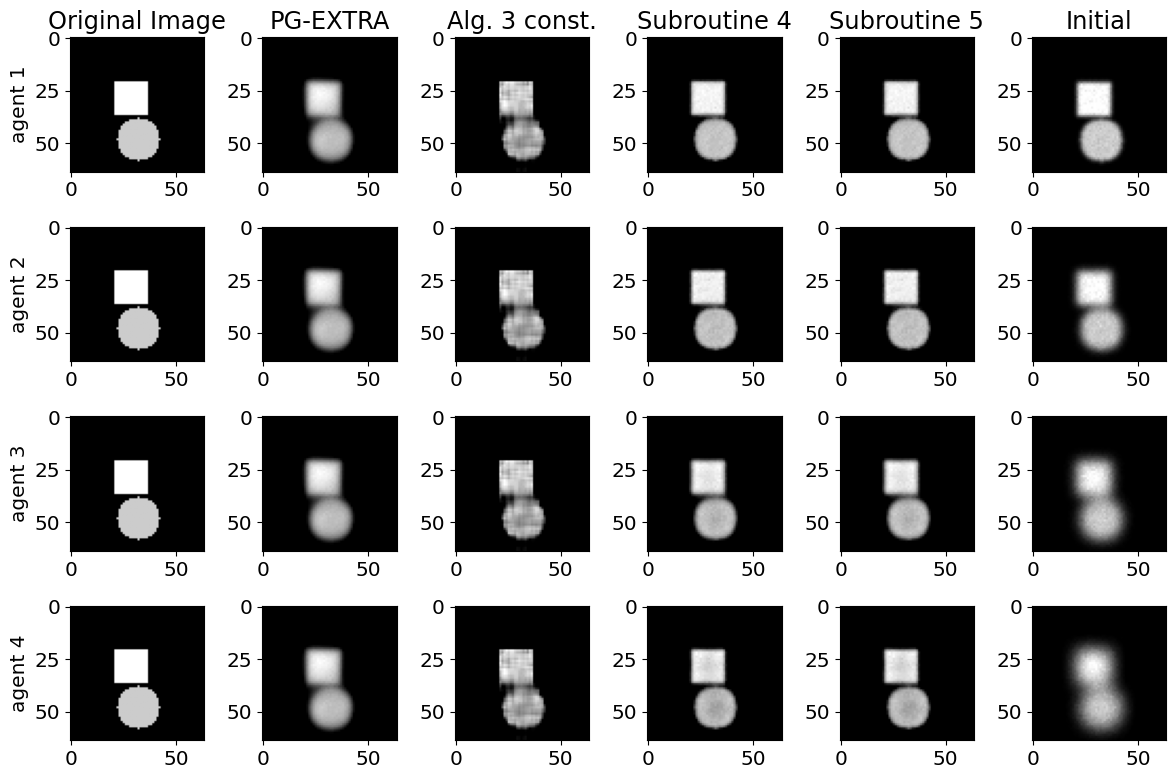

In [129]:
x_truer, beta_cte1r, beta_1r, beta_2r, beta_3r, x_initr = rescale_output(x_true, x_ADT,x_PE, x_1, x_1, x_init)#rescale_output(x_true, beta_cte1, beta_1,x_PE, x_init)

fig, axs = plt.subplots(param['n'], 6, figsize=(12, 8))

for ag in range(param['n']):

  #fig, axs = plt.subplots(1, 6, figsize=(10, 10))

  axs[ag,0].imshow(np.reshape(x_truer, (param['n_dim'], param['n_dim'])), cmap='gray')
  #axs[0].set_title('Original Image')
  axs[ag,0].set_ylabel("agent "+str(ag+1))

  axs[ag,1].imshow(np.reshape(beta_1r[ag], (param['n_dim'], param['n_dim'])), cmap='gray')
  #axs[1].set_title('Constant ADT')

  axs[ag,2].imshow(np.reshape(beta_cte1r[ag], (param['n_dim'], param['n_dim'])), cmap='gray')
  #axs[2].set_title('PG EXTRA')

  axs[ag,3].imshow(np.reshape(beta_2r[ag], (param['n_dim'], param['n_dim'])), cmap='gray')
  #axs[3].set_title('LS1')

  axs[ag,4].imshow(np.reshape(beta_3r[ag], (param['n_dim'], param['n_dim'])), cmap='gray')

  axs[ag,5].imshow(np.reshape(x_initr[ag], (param['n_dim'], param['n_dim'])), cmap='gray')
  #axs[4].set_title('Initial')

  if ag == 0:
    axs[ag,0].set_title('Original Image')
    axs[ag,1].set_title('PG-EXTRA')
    axs[ag,2].set_title('Alg. 3 const.')
    axs[ag,3].set_title('Subroutine 4')
    axs[ag,4].set_title('Subroutine 5')
    axs[ag,5].set_title('Initial')

plt.rcParams.update({'font.size': 14})
plt.tight_layout()
#plt.savefig("5.1-poisson-2.png", dpi=300, bbox_inches="tight")
plt.show()

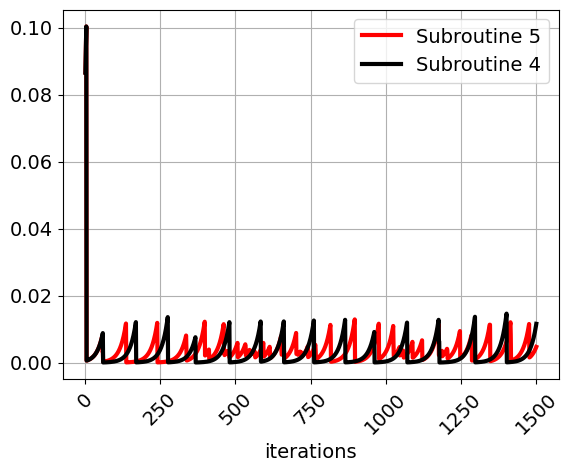

In [130]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

to_plot = t_hist_2
x = np.linspace(1, len(to_plot), num=len(to_plot))
ax.plot(x, to_plot, 'r-', label='Subroutine 5', linewidth=3)

to_plot = t_hist_1
x = np.linspace(1, len(to_plot), num=len(to_plot))
ax.plot(x, to_plot, 'k-', label='Subroutine 4', linewidth=3)


plt.xlabel("iterations")
plt.legend()
plt.grid(True, which="both")
plt.rcParams.update({'font.size': 14.5})
plt.xticks(rotation=45)
#plt.savefig("5.1-poisson-step-2a.png", dpi=300, bbox_inches="tight")
plt.show()

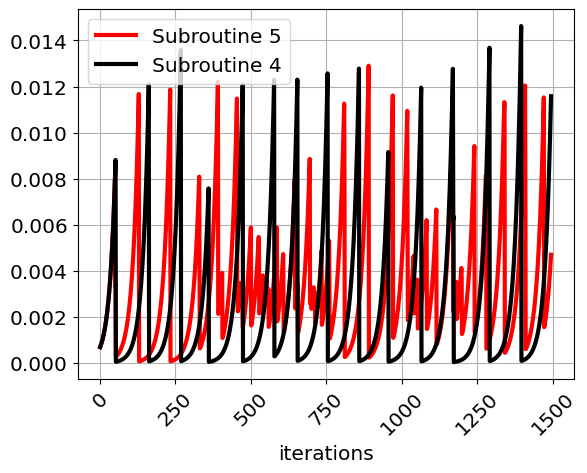

In [131]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

st = 7

to_plot = t_hist_2[st:]
x = np.linspace(1, len(to_plot), num=len(to_plot))
ax.plot(x, to_plot, 'r-', label='Subroutine 5', linewidth=3)

to_plot = t_hist_1[st:]
x = np.linspace(1, len(to_plot), num=len(to_plot))
ax.plot(x, to_plot, 'k-', label='Subroutine 4', linewidth=3)


plt.xlabel("iterations")
plt.legend()
plt.grid(True, which="both")
plt.rcParams.update({'font.size': 14.5})
plt.xticks(rotation=45)
#plt.savefig("5.1-poisson-step-2b.png", dpi=300, bbox_inches="tight")
plt.show()

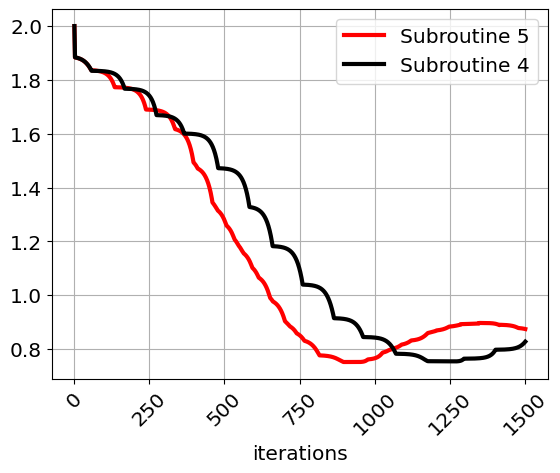

In [132]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

to_plot = feas_2
x = np.linspace(1, len(to_plot), num=len(to_plot))
ax.plot(x, to_plot, 'r-', label='Subroutine 5', linewidth=3)

to_plot = feas_1
x = np.linspace(1, len(to_plot), num=len(to_plot))
ax.plot(x, to_plot, 'k-', label='Subroutine 4', linewidth=3)


plt.xlabel("iterations")
plt.legend()
plt.grid(True, which="both")
plt.rcParams.update({'font.size': 14.5})
plt.xticks(rotation=45)
#plt.savefig("5.1-poisson-feas-2.png", dpi=300, bbox_inches="tight")
plt.show()

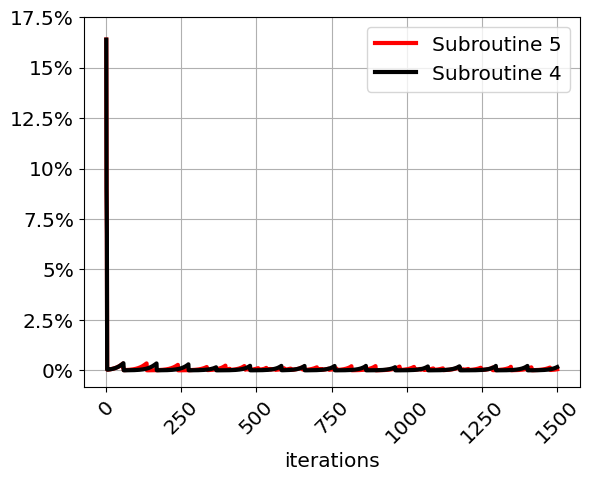

In [133]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

to_plot1 = [dx_2[i]/np.sqrt(in_pr(x_init - param['x_true_stack'],x_init - param['x_true_stack'])) for i in range(len(dx_2))]
x = np.linspace(1, len(to_plot1), num=len(to_plot1))
ax.plot(x, to_plot1, 'r-', label='Subroutine 5', linewidth=3)

to_plot2 = [dx_1[i]/np.sqrt(in_pr(x_init - param['x_true_stack'],x_init - param['x_true_stack'])) for i in range(len(dx_1))]
x = np.linspace(1, len(to_plot2), num=len(to_plot2))
ax.plot(x, to_plot2, 'k-', label='Subroutine 4', linewidth=3)


plt.xlabel("iterations")
plt.legend()
plt.grid(True, which="both")
plt.rcParams.update({'font.size': 14.5})
plt.xticks(rotation=45)
plt.yticks([0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175], ['0%', '2.5%', '5%', '7.5%', '10%', '12.5%', '15%', '17.5%'])
#plt.savefig("5.1-poisson-re-2a.png", dpi=300, bbox_inches="tight")
plt.show()

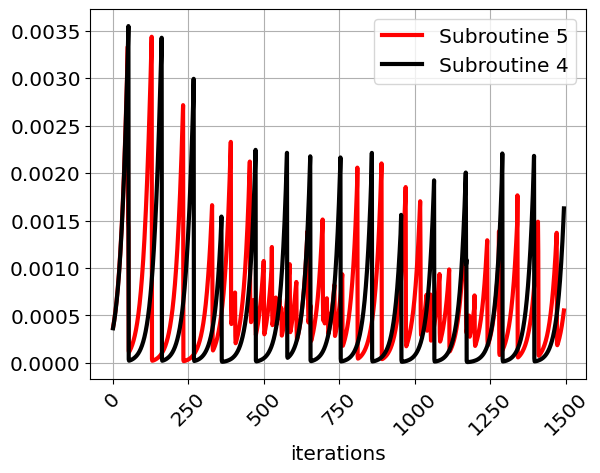

In [134]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

to_plot1 = [dx_2[i]/np.sqrt(in_pr(x_init - param['x_true_stack'],x_init - param['x_true_stack'])) for i in range(6,len(dx_2))]
x = np.linspace(1, len(to_plot1), num=len(to_plot1))
ax.plot(x, to_plot1, 'r-', label='Subroutine 5', linewidth=3)

to_plot2 = [dx_1[i]/np.sqrt(in_pr(x_init - param['x_true_stack'],x_init - param['x_true_stack'])) for i in range(6,len(dx_1))]
x = np.linspace(1, len(to_plot2), num=len(to_plot2))
ax.plot(x, to_plot2, 'k-', label='Subroutine 4', linewidth=3)


plt.xlabel("iterations")
plt.legend()
plt.grid(True, which="both")
plt.rcParams.update({'font.size': 14.5})
plt.xticks(rotation=45)
#plt.yticks([0, 0.0005, 0.001, 0.0015, 0.002, 0.0025], ['0%', '0.05%', '0.1%', '0.15%', '0.2%', '0.25%'])
#plt.savefig("5.1-poisson-re-2b.png", dpi=300, bbox_inches="tight")
plt.show()